# Ward level census data

- [Method of travel to  work (2011)](https://www.nomisweb.co.uk/census/2011/qs701ew)
- [Car and van ownership (2011)](https://www.nomisweb.co.uk/census/2011/qs416ew)
- [Deprivation dimensions (2011)](https://www.nomisweb.co.uk/census/2011/qs119ew)
- [Ward boundaries (2011)](https://statistics.ukdataservice.ac.uk/dataset/2011-census-geography-boundaries-wards-and-electoral-divisions)
- [Ward changes 2011 - 2021](https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2011-to-lsoa-2021-to-local-authority-district-2022-lookup-for-england-and-wales/explore)
- [Oxford ward population (2011)](https://www.oxford.gov.uk/downloads/file/1082/ward_population)
  

In [11]:
import pathlib
import kml2geojson
import json
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline


## Ward codes for Oxford

In [16]:
## Need to get list of geography codes for Oxford
ward_data_file = 'data/infuse_ward_lyr_2011.csv'
df_ward_data = pd.read_csv(ward_data_file)

In [17]:
# Geo codes for Oxford wards are sequential from E05006545 (Barton and Sandhills) to E05006568 (Wolvercote)
# There are 22 wards when you do this - and there are some missing from the middle when you plot them 
# E05006566 and E05006554 are missing from the sequence for some reason 
# We're also missing some wards from the 
valid_geo_codes = set([f'E050065{str(i).zfill(2)}' for i in range(45, 69)])
df_ward_data_ox = df_ward_data[df_ward_data['geo_code'].isin(valid_geo_codes)]

In [19]:
assert len(df_ward_data_ox) == 22  # Missing 2 wards

In [26]:
describe = df_ward_data_ox.describe()
xmin = describe['x']['min']
xmax = describe['x']['max']
ymin = describe['y']['min']
ymax = describe['y']['max']

In [27]:
# Get the missing wards by using x-y range 
df_ward_data_ox_missing = df_ward_data[(df_ward_data['x'] > xmin) & (df_ward_data['x'] < xmax) & (df_ward_data['y'] > ymin) & (df_ward_data['y'] < ymax)]

In [29]:
set(df_ward_data_ox_missing['name'].unique().tolist()) - set(df_ward_data_ox['name'].unique().tolist())

{"Holywell,St Mary's", 'Kennington and South Hinksey'}

In [30]:
# Add the Holywell ward to the list of valid geo codes
df_ward_data_ox = df_ward_data_ox.append(df_ward_data_ox_missing[df_ward_data_ox_missing['name'].str.contains('Holywell')])

In [31]:
df_ward_data_ox

,geo_code,geo_label,geo_labelw,label,name,x,y
526,E05006552,Headington Hill and Northway,NaN,E92000001E05006552,Headington Hill and Northway,453405.762192,207446.819071
656,E05006568,Wolvercote,NaN,E92000001E05006568,Wolvercote,449665.070943,209944.477139
688,E05006547,Carfax,NaN,E92000001E05006547,Carfax,451089.983769,206249.417512
1326,E05006557,Littlemore,NaN,E92000001E05006557,Littlemore,453974.964558,202726.592572
1542,E05006545,Barton and Sandhills,NaN,E92000001E05006545,Barton and Sandhills,455291.094428,207824.587715
1599,E05006563,Rose Hill and Iffley,NaN,E92000001E05006563,Rose Hill and Iffley,453127.621705,203622.109948
1887,E05006558,Lye Valley,NaN,E92000001E05006558,Lye Valley,455615.876985,204442.175561
2266,E05006562,Quarry and Risinghurst,NaN,E92000001E05006562,Quarry and Risinghurst,455560.976487,206950.857970
2708,E05006555,Iffley Fields,NaN,E92000001E05006555,Iffley Fields,452752.066493,204829.436151
3454,E05006565,St Margaret's,NaN,E92000001E05006565,St Margaret's,450956.804059,208403.635955


In [32]:
# Update the valid geo codes
valid_geo_codes = set(df_ward_data_ox['geo_code'].unique().tolist())

In [33]:
# Let's print a nice map of these wards 
# We'll use the kml2geojson library to convert the kml file to geojson
# Then we'll use the geojson library to print the map
ward_data_kml = 'data/infuse_ward_lyr_2011.kml' 
ward_data_geojson_file = 'data/oxford_ward_data.geojson'

if not pathlib.Path(ward_data_geojson_file).exists():
    ward_data_geojson = kml2geojson.main.convert(ward_data_kml)  # Takes 90s to run, only needs to be run once to generate the geojson file
    # Filter geojson to only include the wards we want
    ward_data_geojson[0]['features'] = [feature for feature in ward_data_geojson[0]['features'] if feature['properties']['geo_code'] in valid_geo_codes]
    # Dump this geojson to a file
    with open(ward_data_geojson_file, 'w') as f:
        json.dump(ward_data_geojson[0], f)
else:
    with open(ward_data_geojson_file, 'r') as f:
        ward_data_geojson = json.load(f)

In [67]:
df_ward_geo = gpd.read_file(ward_data_geojson_file)

In [68]:
df_ward_geo

,name,fill-opacity,stroke,stroke-opacity,geo_code,geo_label,label,geometry
0,Headington Hill and Northway,0.0,#ff0000,1.0,E05006552,Headington Hill and Northway,E92000001E05006552,"POLYGON ((-1.22982 51.77007, -1.22981 51.77007..."
1,Wolvercote,0.0,#ff0000,1.0,E05006568,Wolvercote,E92000001E05006568,"POLYGON ((-1.28988 51.79039, -1.28987 51.79039..."
2,Carfax,0.0,#ff0000,1.0,E05006547,Carfax,E92000001E05006547,"POLYGON ((-1.26348 51.75375, -1.26348 51.75376..."
3,Littlemore,0.0,#ff0000,1.0,E05006557,Littlemore,E92000001E05006557,"POLYGON ((-1.22395 51.72681, -1.22402 51.72694..."
4,Barton and Sandhills,0.0,#ff0000,1.0,E05006545,Barton and Sandhills,E92000001E05006545,"POLYGON ((-1.20859 51.76701, -1.20860 51.76706..."
5,Rose Hill and Iffley,0.0,#ff0000,1.0,E05006563,Rose Hill and Iffley,E92000001E05006563,"POLYGON ((-1.24112 51.73172, -1.24112 51.73173..."
6,Lye Valley,0.0,#ff0000,1.0,E05006558,Lye Valley,E92000001E05006558,"POLYGON ((-1.20936 51.74661, -1.20936 51.74662..."
7,Quarry and Risinghurst,0.0,#ff0000,1.0,E05006562,Quarry and Risinghurst,E92000001E05006562,"POLYGON ((-1.20086 51.76235, -1.20081 51.76236..."
8,Iffley Fields,0.0,#ff0000,1.0,E05006555,Iffley Fields,E92000001E05006555,"POLYGON ((-1.23128 51.74370, -1.23126 51.74369..."
9,St Margaret's,0.0,#ff0000,1.0,E05006565,St Margaret's,E92000001E05006565,"POLYGON ((-1.26498 51.77535, -1.26498 51.77536..."


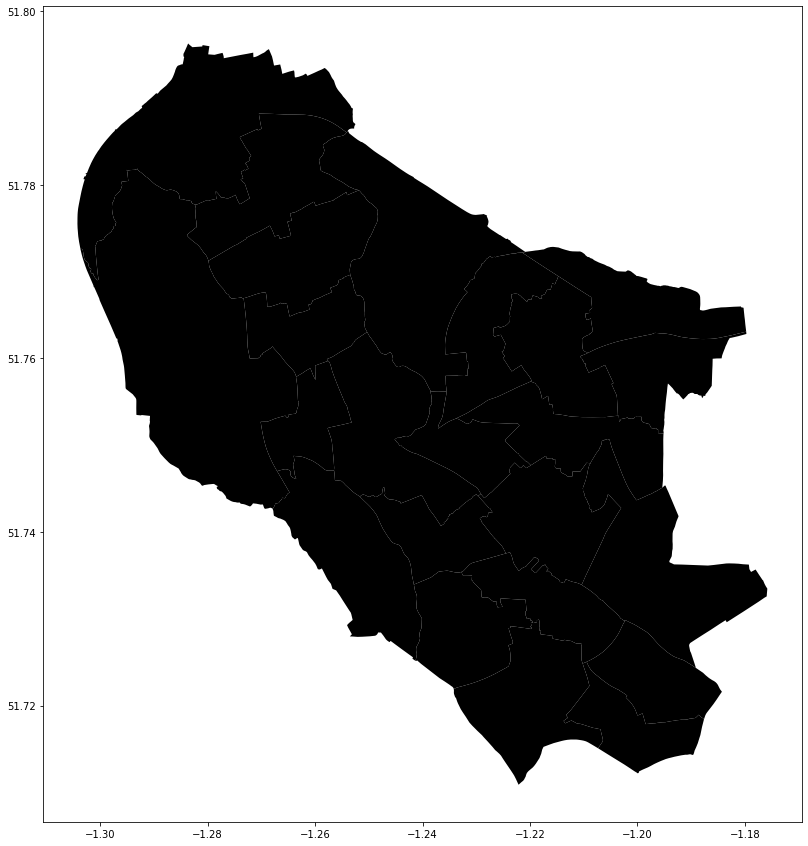

In [36]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = df_ward_geo.plot(column='stroke', cmap='afmhot' ,ax=ax)
plt.show()

## Deprivation data

In [37]:
deprivation_data_file = 'data/deprivation_2011.csv'
df_deprivation = pd.read_csv(deprivation_data_file)

In [42]:
# Filter to only include the wards we want 
df_deprivation = df_deprivation[df_deprivation['geography code'].isin(valid_geo_codes)]

In [62]:
# Add column for average number of deprivation indices by ward 
def average_deprivation_index(num_households, num_households_zero, num_households_one, num_households_two, num_households_three, num_households_four):
    return (0 * int(num_households_zero) + 1 * int(num_households_one) + 2 * int(num_households_two) + 3 * int(num_households_three) + 4 * int(num_households_four)) / int(num_households)

cols = df_deprivation.columns
df_deprivation['average_deprivation_index'] = df_deprivation.apply(lambda x: average_deprivation_index(
    x[cols[4]], x[cols[5]], x[cols[6]], x[cols[7]], x[cols[8]], x[cols[9]]), axis=1)

In [63]:
df_deprivation.head()

,date,geography,geography code,Rural Urban,Household Deprivation: All categories: Classification of household deprivation; measures: Value,Household Deprivation: Household is not deprived in any dimension; measures: Value,Household Deprivation: Household is deprived in 1 dimension; measures: Value,Household Deprivation: Household is deprived in 2 dimensions; measures: Value,Household Deprivation: Household is deprived in 3 dimensions; measures: Value,Household Deprivation: Household is deprived in 4 dimensions; measures: Value,average_deprivation_index
6164,2011,Barton and Sandhills,E05006545,Total,2850,1197,919,518,196,20,0.920351
6165,2011,Blackbird Leys,E05006546,Total,2361,618,848,638,227,30,1.238882
6166,2011,Carfax,E05006547,Total,1246,506,466,181,80,13,0.898876
6167,2011,Churchill,E05006548,Total,2527,952,904,520,135,16,0.954887
6168,2011,Cowley,E05006549,Total,2487,1039,793,503,139,13,0.911942


In [69]:
# Merge deprivation data with ward data, adding average deprivation index to df_ward_geo
df_ward_geo = df_ward_geo.merge(df_deprivation[['geography code', 'average_deprivation_index']], left_on='geo_code', right_on='geography code')

In [70]:
df_ward_geo

,name,fill-opacity,stroke,stroke-opacity,geo_code,geo_label,label,geometry,geography code,average_deprivation_index
0,Headington Hill and Northway,0.0,#ff0000,1.0,E05006552,Headington Hill and Northway,E92000001E05006552,"POLYGON ((-1.22982 51.77007, -1.22981 51.77007...",E05006552,0.741603
1,Wolvercote,0.0,#ff0000,1.0,E05006568,Wolvercote,E92000001E05006568,"POLYGON ((-1.28988 51.79039, -1.28987 51.79039...",E05006568,0.604319
2,Carfax,0.0,#ff0000,1.0,E05006547,Carfax,E92000001E05006547,"POLYGON ((-1.26348 51.75375, -1.26348 51.75376...",E05006547,0.898876
3,Littlemore,0.0,#ff0000,1.0,E05006557,Littlemore,E92000001E05006557,"POLYGON ((-1.22395 51.72681, -1.22402 51.72694...",E05006557,0.860059
4,Barton and Sandhills,0.0,#ff0000,1.0,E05006545,Barton and Sandhills,E92000001E05006545,"POLYGON ((-1.20859 51.76701, -1.20860 51.76706...",E05006545,0.920351
5,Rose Hill and Iffley,0.0,#ff0000,1.0,E05006563,Rose Hill and Iffley,E92000001E05006563,"POLYGON ((-1.24112 51.73172, -1.24112 51.73173...",E05006563,0.941683
6,Lye Valley,0.0,#ff0000,1.0,E05006558,Lye Valley,E92000001E05006558,"POLYGON ((-1.20936 51.74661, -1.20936 51.74662...",E05006558,0.817593
7,Quarry and Risinghurst,0.0,#ff0000,1.0,E05006562,Quarry and Risinghurst,E92000001E05006562,"POLYGON ((-1.20086 51.76235, -1.20081 51.76236...",E05006562,0.680561
8,Iffley Fields,0.0,#ff0000,1.0,E05006555,Iffley Fields,E92000001E05006555,"POLYGON ((-1.23128 51.74370, -1.23126 51.74369...",E05006555,0.713306
9,St Margaret's,0.0,#ff0000,1.0,E05006565,St Margaret's,E92000001E05006565,"POLYGON ((-1.26498 51.77535, -1.26498 51.77536...",E05006565,0.459168


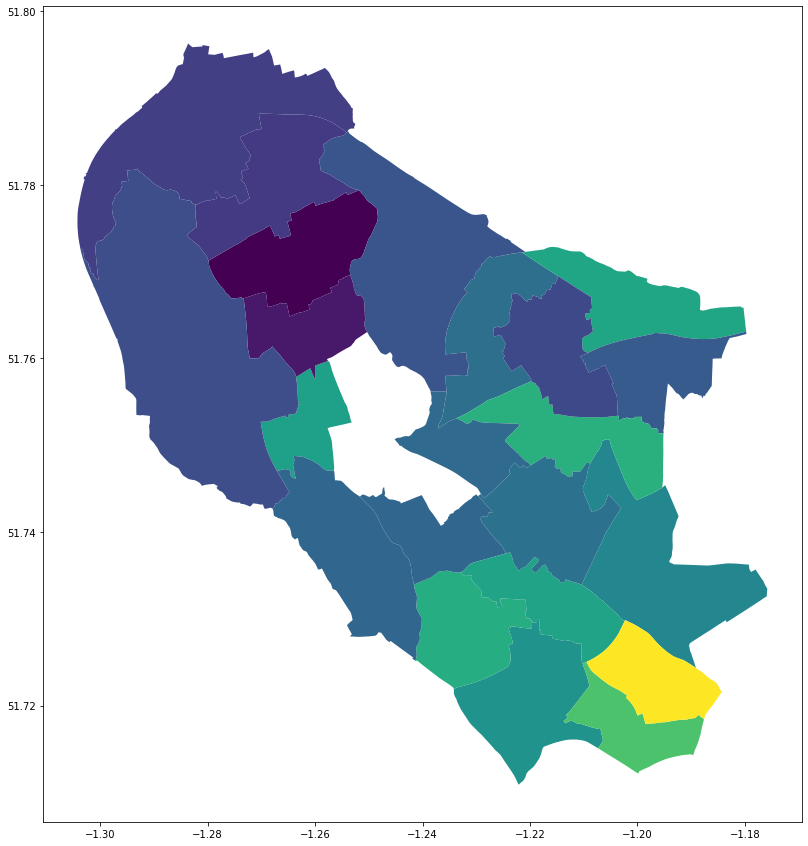

In [72]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = df_ward_geo.plot(column='average_deprivation_index' ,ax=ax)
plt.show()

## Car ownership data

In [75]:
car_ownership_data_file = 'data/car_ownership_2011.csv'
travel_to_work_data_file = 'data/travel_to_work_2011.csv'

df_car_ownership = pd.read_csv(car_ownership_data_file)
df_travel_to_work = pd.read_csv(travel_to_work_data_file)

In [78]:
# Filter to only include the wards we want
df_car_ownership = df_car_ownership[df_car_ownership['geography code'].isin(valid_geo_codes)]
df_travel_to_work = df_travel_to_work[df_travel_to_work['geography code'].isin(valid_geo_codes)]

In [79]:
df_car_ownership.head()

,date,geography,geography code,Rural Urban,Cars: All categories: Car or van availability; measures: Value,Cars: No cars or vans in household; measures: Value,Cars: 1 car or van in household; measures: Value,Cars: 2 cars or vans in household; measures: Value,Cars: 3 cars or vans in household; measures: Value,Cars: 4 or more cars or vans in household; measures: Value,Cars: sum of All cars or vans in the area; measures: Value
6164,2011,Barton and Sandhills,E05006545,Total,2850,895,1320,512,92,31,2754
6165,2011,Blackbird Leys,E05006546,Total,2361,980,1002,304,60,15,1852
6166,2011,Carfax,E05006547,Total,1246,778,383,75,9,1,564
6167,2011,Churchill,E05006548,Total,2527,1050,1039,330,86,22,2069
6168,2011,Cowley,E05006549,Total,2487,835,1132,392,99,29,2339


In [80]:
def average_cars_per_household(num_households, num_households_zero, num_households_one, num_households_two, num_households_three, num_households_four):
    return (0 * int(num_households_zero) + 1 * int(num_households_one) + 2 * int(num_households_two) + 3 * int(num_households_three) + 4 * int(num_households_four)) / int(num_households)

In [81]:
cols = df_car_ownership.columns
df_car_ownership['average_cars_per_household'] = df_car_ownership.apply(lambda x: average_cars_per_household(
    x[cols[4]], x[cols[5]], x[cols[6]], x[cols[7]], x[cols[8]], x[cols[9]]), axis=1)

/var/folders/fg/w06k0nvx1w513ss83703ycf00000gn/T/ipykernel_32103/2912533859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_ownership['average_cars_per_household'] = df_car_ownership.apply(lambda x: average_cars_per_household(


In [83]:
# Add this column to df_ward_geo
df_ward_geo = df_ward_geo.merge(df_car_ownership[['geography code', 'average_cars_per_household']], left_on='geo_code', right_on='geography code')

In [85]:
# Drop the two geography code columns
df_ward_geo = df_ward_geo.drop(columns=['geography code_x', 'geography code_y'])

In [90]:
df_ward_geo.head()

,name,fill-opacity,stroke,stroke-opacity,geo_code,geo_label,label,geometry,average_deprivation_index,average_cars_per_household
0,Headington Hill and Northway,0.0,#ff0000,1.0,E05006552,Headington Hill and Northway,E92000001E05006552,"POLYGON ((-1.22982 51.77007, -1.22981 51.77007...",0.741603,1.020585
1,Wolvercote,0.0,#ff0000,1.0,E05006568,Wolvercote,E92000001E05006568,"POLYGON ((-1.28988 51.79039, -1.28987 51.79039...",0.604319,1.141921
2,Carfax,0.0,#ff0000,1.0,E05006547,Carfax,E92000001E05006547,"POLYGON ((-1.26348 51.75375, -1.26348 51.75376...",0.898876,0.452648
3,Littlemore,0.0,#ff0000,1.0,E05006557,Littlemore,E92000001E05006557,"POLYGON ((-1.22395 51.72681, -1.22402 51.72694...",0.860059,1.027468
4,Barton and Sandhills,0.0,#ff0000,1.0,E05006545,Barton and Sandhills,E92000001E05006545,"POLYGON ((-1.20859 51.76701, -1.20860 51.76706...",0.920351,0.962807


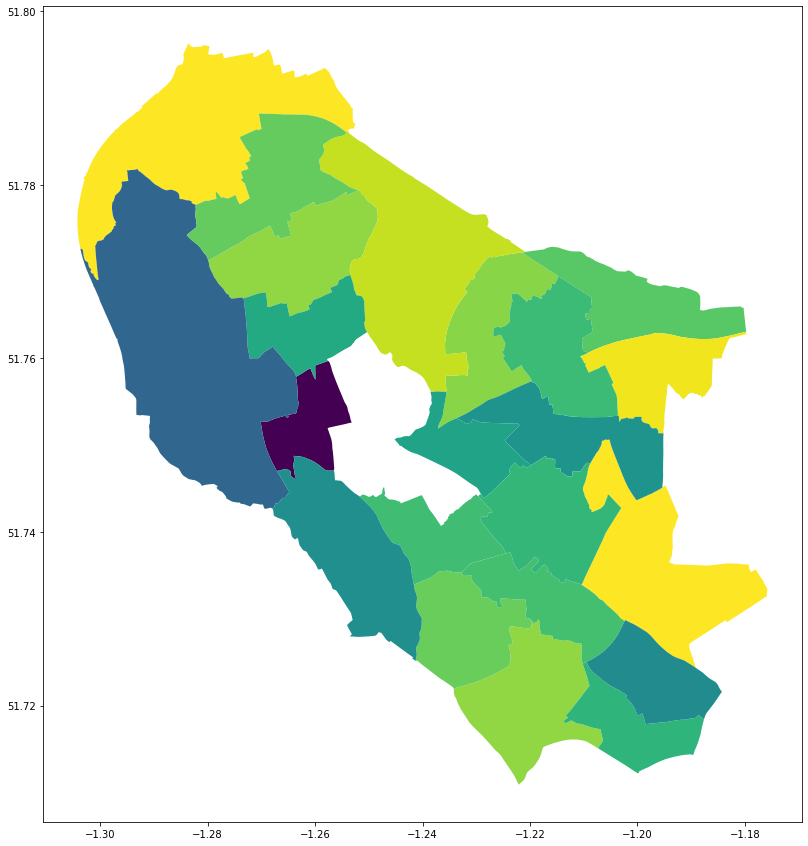

In [87]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = df_ward_geo.plot(column='average_cars_per_household' ,ax=ax)
plt.show()

Text(0, 0.5, 'Average cars per household')

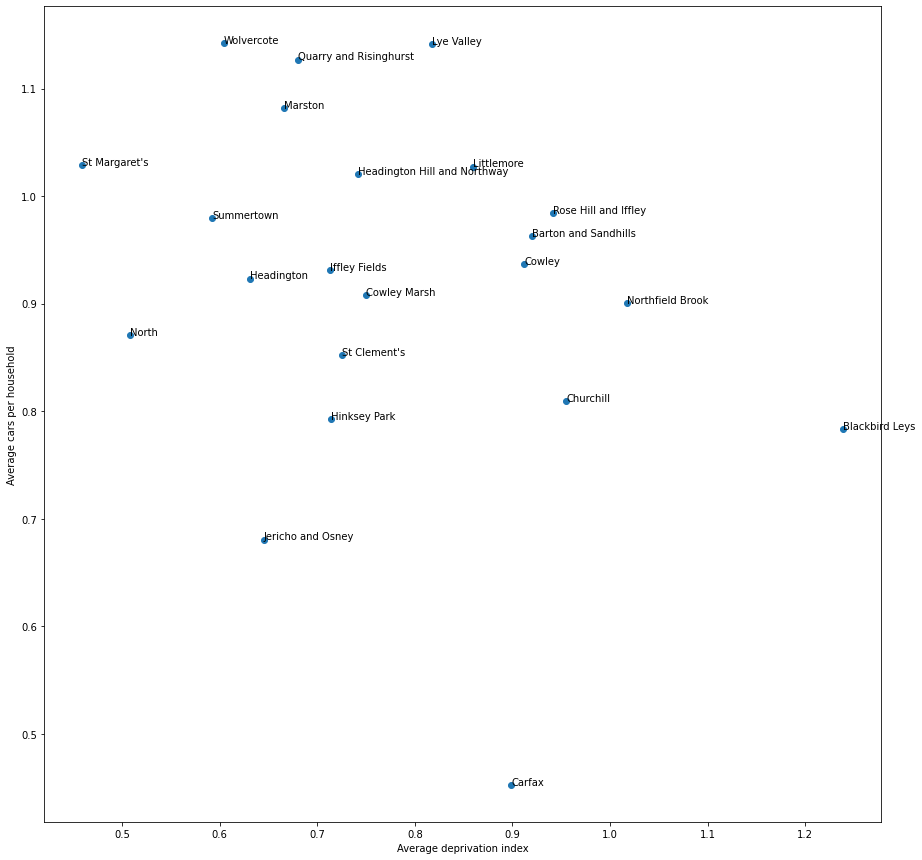

In [92]:
## Plot scatter diagram of deprivation vs car ownership, with ward name labels
f, ax = plt.subplots(1, figsize=(15, 15))
for i, row in df_ward_geo.iterrows():
    plt.annotate(row['name'], (row['average_deprivation_index'], row['average_cars_per_household']))
plt.scatter(df_ward_geo['average_deprivation_index'], df_ward_geo['average_cars_per_household'])
plt.xlabel('Average deprivation index')
plt.ylabel('Average cars per household')

In [ ]:
# Idea: add a "distance to city centre" column to df_ward_geo
# Probably: centroid of ward to Carfax tower
